# Archetype Task Drug Response -- newer version

Y:Tissue repair/homeostasis: Hedgehog, Insulin-like growth factor, ﬁbroblast growth factor, Wnt, TGFβ, Ras

GR AOC is a measure of drug sensitivity robust to cell-to-cell variations in growth rates38. We determined how the GR AOC varied as a function of euclidean distance to the archetype by grouping cell lines in four distance bins. For each bin i, we computed the median GR AOC Gi and the within-bin standard error σi. Because some drugs were assayed against only some of the 56 cell lines, we discarded drugs with <5 cell lines per bin. For each archetype, we looked for drugs whose potency peaked in cell lines closest to the archetype, and then monotonically decreases away from it. To address the concern that the small sample size (56 breast cancer cell lines vs 1970 breast tumors per cancer type) can produce false positive drug-archetype pairs, we used a more stringent criterion to identify drugs effective against individual archetypes than the criteria used to ﬁnd overrepresented MSigDB pathway and clinical features (see “enrichment analysis” section). We scored each drug by the product of the decrease in GR AOC in consecutive bins plus twice the standard error within bin, Πi (Gi—Gi+1 + 2 <σi>), with <σi> the median standard error across all bins. Drugs which score high on this scheme see their GR AOC peak close to the archetype and then steadily decrease away from it. If GR AOC increased by more than twice the standard error in any consecutive bins, the score was set to 0. This tolerates small bin-to-bin increase in GR AOC which could be due to measurement error or cell-to-cell variability. Finally, we tested if GR AOC was signiﬁcantly higher in cell lines of the ﬁrst distance bin compared with all other bins (FDR < 10%, Mann–Whitney test, see “enrichment analysis” section). In doing so, everolimus, rapaycin, and temsirolimus were grouped together as they share the same mechanism (mTOR inhibition, Fig. 2g). Of the top ten-scoring drugs, six appear on Fig. 2e–h. In addition to these six drugs, Triciribine which inhibits the Akt kinase (an mTOR activator) is effective against the biomass and energy archetype (p = 0.01), consistent with the sensitivity of the biomass and energy archetype to mTOR inhibitors (Fig. 2g). Gemcitabine, another drug in the top 10, was not statistically signiﬁcant at FDR < 10% (p = 0.11). The identity of the remaining drugs within the top 10 was kept conﬁdential by the authors of the dataset14, thereby preventing further interpretation.

**Direction of MYC amplification/ CNV changes
aligned with new archetype?**

In [5]:
import pandas as pd
import numpy as np
import scipy as sc
import os.path as op
import matplotlib.pyplot as plt
import seaborn as sns

## Get distance and drug data

In [7]:
indir = '/Users/smgroves/Documents/GitHub/Groves-CellSys2021/'
distances = pd.read_csv(op.join(indir, 'notebooks/out/bulk/dist_to_bulk_arc.csv'), index_col=0)

In [8]:
distances.index = [i.split(".")[1] for i in distances.index]

In [9]:
distances_groupby_cline = distances.groupby(distances.index).mean()

In [10]:
distances_groupby_cline.to_csv(op.join(indir, 'notebooks/out/dist_to_bulk_arc_by_cline.csv'))

In [11]:
subset = distances_groupby_cline.loc[['NCIH69','DMS53','DMS454','CORL279','NCIH524','NCIH82','NCIH1048','NCIH841']]


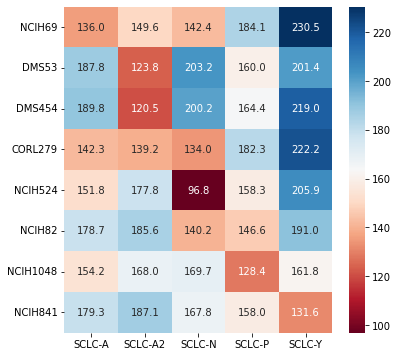

In [354]:
hm_df = (subset - subset.min())/(subset.max()- subset.min())
plt.figure(figsize = (6,6))
sns.heatmap(subset.sort_index(axis = 1), annot = True, fmt = '.1f',  cmap = 'RdBu')
plt.savefig('./figures/distances_cline_to_arc.pdf')

In [12]:
dr = pd.read_csv(op.join(indir, 'data/drug-response/Teicher_viability_params.tsv'), delimiter='\t')

In [13]:
target_df = pd.read_csv(op.join(indir, 'data/drug-response/target_list_all.csv'))

In [14]:
target_df.head()

,TARGET,DRUGS
0,5-FU,Capecitabine
1,5-HT,Paroxetine
2,5-HT RECEPTOR,Anafranil
3,7-TM RECEPTORS,Terfenadine
4,ABL,"Imatinib, Nilotinib, Ponatinib"


## Scoring each drug

Product of the decrease in consecutive bins + 2* SE for the bin (G_i -G[i+1] +2* SE_i)
This allows for small increases between bins (less than 2 * SE), but if the increase between bins is twice the SE of that bin, the score is low/zero.

In [15]:
cell_lines = set(dr.cell_line.unique()).intersection(set(distances_groupby_cline.index))

In [16]:
len(dr.cell_line.unique())

70

In [17]:
dr = dr.loc[(dr.cell_line.isin(cell_lines))]

In [18]:
dr = dr.reset_index()


In [19]:

for c in distances_groupby_cline.columns:
    groups = pd.cut(distances_groupby_cline[c], bins = 4, labels=['A','B','C','D'])
    dr[f"{c}_groups"] = groups[dr.cell_line].reset_index()[c]    
    

In [20]:
pd.cut(distances_groupby_cline[c], bins = 4).unique().sort_values()

[(76.191, 113.249], (113.249, 150.16], (150.16, 187.071], (187.071, 223.982]]
Categories (4, interval[float64, right]): [(76.191, 113.249] < (113.249, 150.16] < (150.16, 187.071] < (187.071, 223.982]]

In [21]:
from scipy.stats import mannwhitneyu
aa_score = pd.DataFrame(index = dr.drug.unique(), columns=[i for i in dr.columns if '_group' in i])
p_values = pd.DataFrame(index = dr.drug.unique(), columns=[i for i in dr.columns if '_group' in i])

for g in aa_score.columns:
    for d in dr.drug.unique():
        tmp = dr.loc[dr.drug ==d]
        close = tmp.loc[tmp[g] == 'A']['aa'].dropna()
        far = tmp.loc[tmp[g] != 'A']['aa'].dropna()
        if (len(close) == 0) or (len(far) == 0): continue

        med_tmp = tmp.groupby(g).median()['aa']
        std_tmp = tmp.groupby(g).sem()['aa']
        median_std_tmp = std_tmp.median(skipna=True)
        prod = 1
        for i,j in zip(['A','B','C'],['B','C','D']):
            if (med_tmp[j]- med_tmp[i]) > 2* median_std_tmp:
                prod = 0
                break
            prod *= med_tmp[i] - med_tmp[j] + 2* median_std_tmp

        aa_score.loc[d,g] = prod
        if prod > 0:
            try:
                stat, p = mannwhitneyu(close, far, alternative='greater')
                p_values.loc[d,g] = p
            except TypeError: print(d)



In [22]:
from statsmodels.stats import multitest
rej, p_corr, _, _ = multitest.multipletests(p_values.melt(ignore_index=False)['value'].dropna().values.astype(float), method='fdr_bh')

In [23]:
p_corr.min()

0.1547812971342383

In [24]:
p_values.sort_values('SCLC-P_groups')

,SCLC-Y_groups,SCLC-P_groups,SCLC-N_groups,SCLC-A2_groups,SCLC-A_groups
ixabepilone,0.256423,0.000161,0.190183,NaN,NaN
floxuridine,NaN,0.000282,NaN,NaN,NaN
Valrubicin,0.782732,0.000317,NaN,NaN,0.107646
clofarabine,NaN,0.000443,0.77878,NaN,NaN
paclitaxel,0.133333,0.000636,0.37989,NaN,NaN
...,...,...,...,...,...
XL-541,0.069452,NaN,0.970073,NaN,0.435272
XL-765,0.301675,NaN,0.656565,0.651047,NaN
Y-27632,0.339921,NaN,0.966897,0.139796,0.226842
YM-155,0.462549,NaN,0.291238,NaN,0.205081


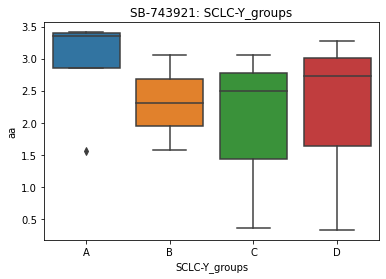

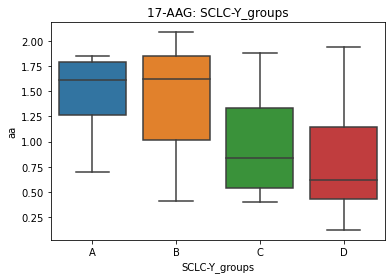

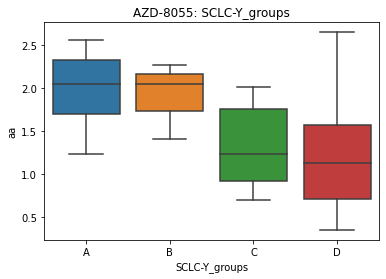

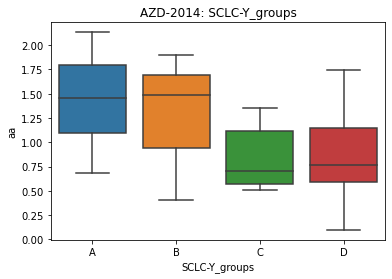

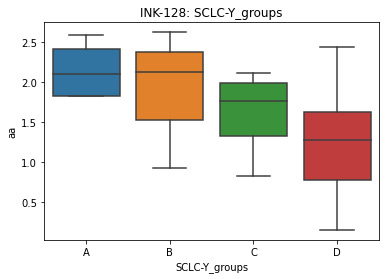

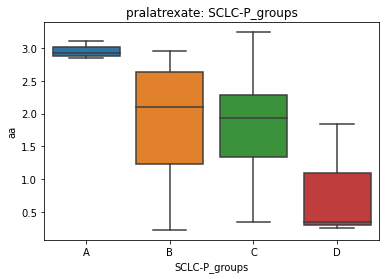

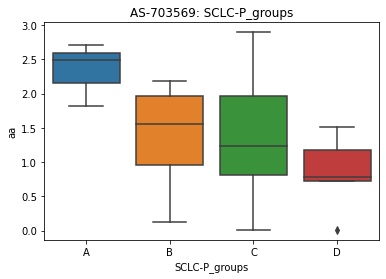

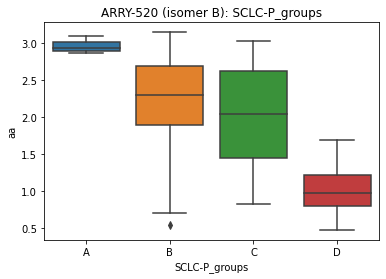

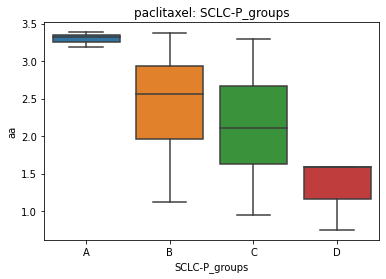

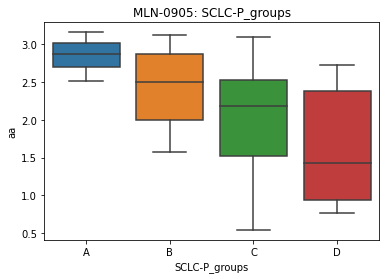

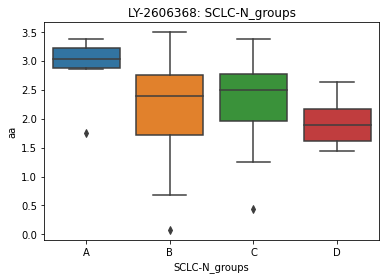

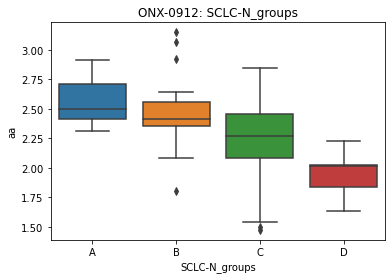

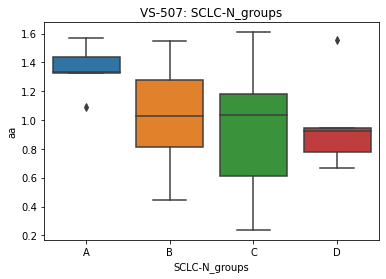

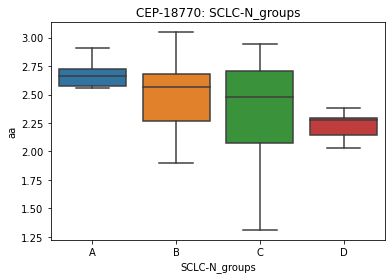

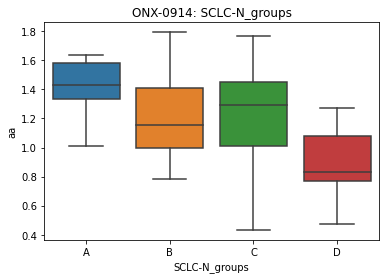

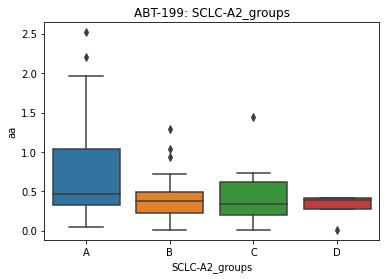

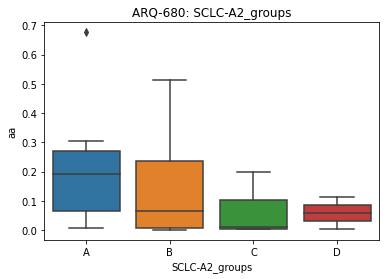

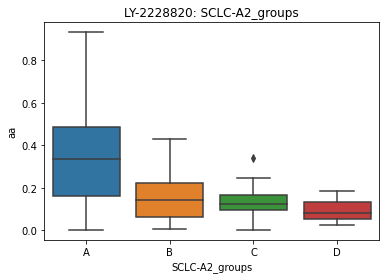

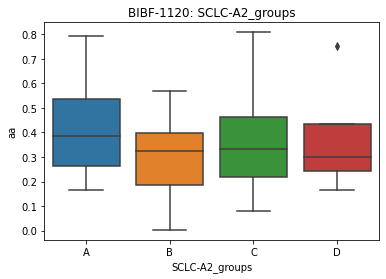

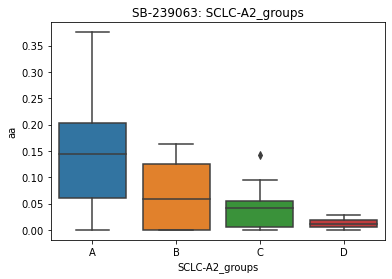

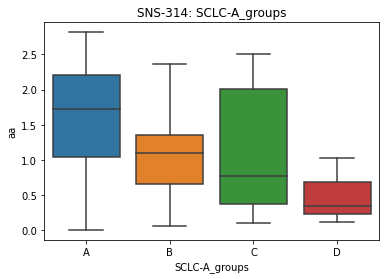

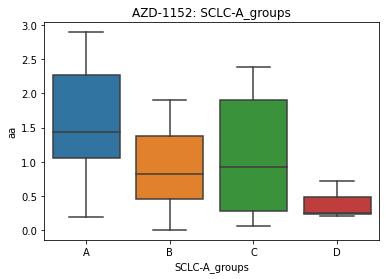

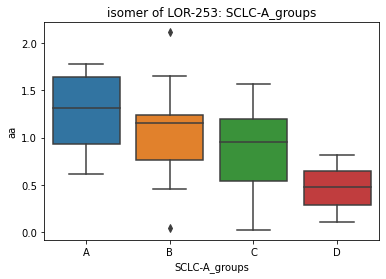

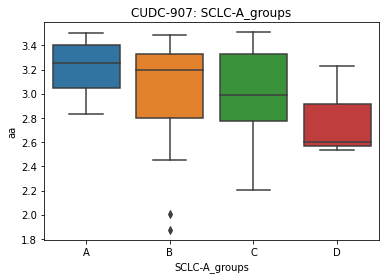

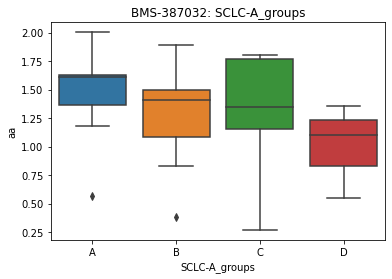

In [25]:
for g in [j for j in dr.columns if '_group' in j]:
    for i in aa_score.loc[p_values.loc[p_values[g] < 0.05].index].sort_values(g, ascending = False).head().index:
        sns.boxplot(data=dr.loc[dr.drug ==i], x = g, y = 'aa')
        plt.title(i + ": " + g)
        plt.show()

## AA observed

In [26]:
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest

def enriched_dr(metric):
    aa_obs_score = pd.DataFrame(index = dr.drug.unique(), columns=[i for i in dr.columns if '_group' in i])
    p_values_obs = pd.DataFrame(index = dr.drug.unique(), columns=[i for i in dr.columns if '_group' in i])
    for g in aa_obs_score.columns:
        for d in dr.drug.unique():
            tmp = dr.loc[dr.drug ==d]
            close = tmp.loc[tmp[g] == 'A'][metric].dropna()
            far = tmp.loc[tmp[g] != 'A'][metric].dropna()
            if (len(close) == 0) or (len(far) == 0): continue

            med_tmp = tmp.groupby(g).median()[metric]
            std_tmp = tmp.groupby(g).sem()[metric]
            median_std_tmp = std_tmp.median(skipna=True)
            prod = 1
            for i,j in zip(['A','B','C'],['B','C','D']):
                if (med_tmp[j]- med_tmp[i]) > 2* median_std_tmp:
                    prod = 0
                    break
                prod *= med_tmp[i] - med_tmp[j] + 2* median_std_tmp

            aa_obs_score.loc[d,g] = prod
            if prod > 0:
                try:
                    stat, p = mannwhitneyu(close, far, alternative='greater')
                    p_values_obs.loc[d,g] = p
                except TypeError: print(d)
    rej, p_corr, _, _ = multitest.multipletests(p_values_obs.melt(ignore_index=False)['value'].dropna().values.astype(float), method='fdr_bh')
    p_corrected = p_values_obs.melt(ignore_index=False).dropna()
    p_corrected.value = p_corr
    sig_drugs = []
    for g in [j for j in dr.columns if '_group' in j]:
        for i in aa_obs_score.loc[p_values_obs.loc[p_values_obs[g] < 0.05].index].sort_values(g, ascending = False).head().index:
            sig_drugs.append(i)
            sns.boxplot(data=dr.loc[dr.drug ==i], x = g, y = metric)
            plt.title(i + ": " + g)
            plt.show()
    return aa_obs_score, p_corrected, p_values_obs, sig_drugs

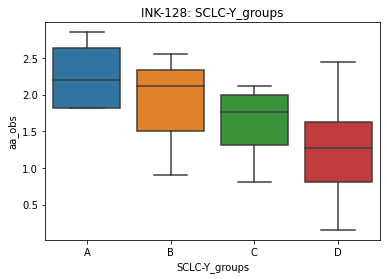

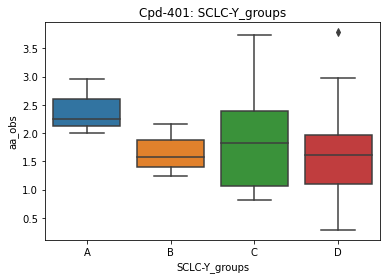

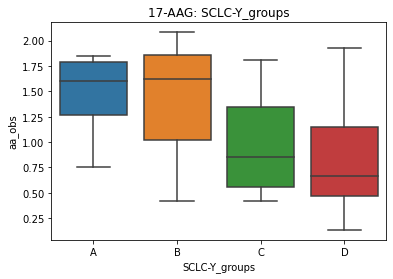

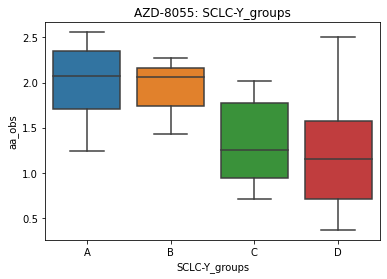

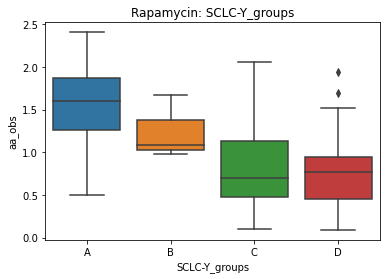

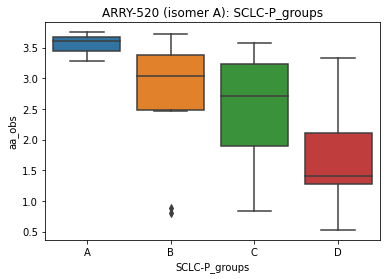

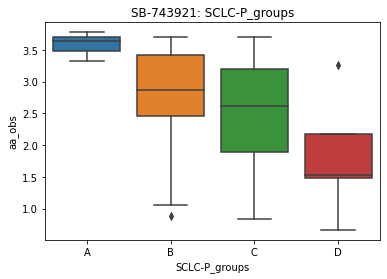

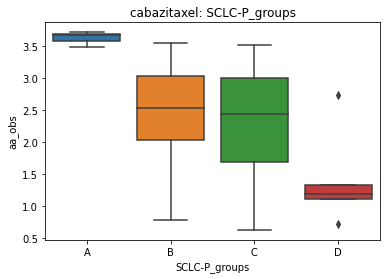

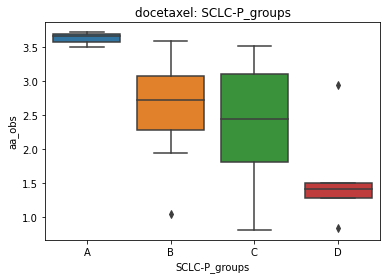

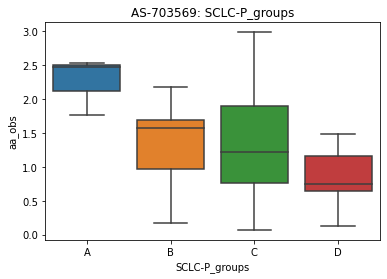

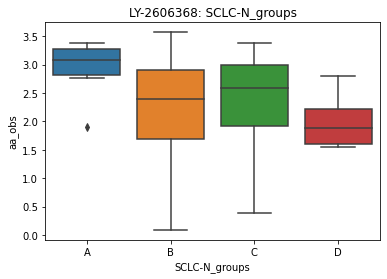

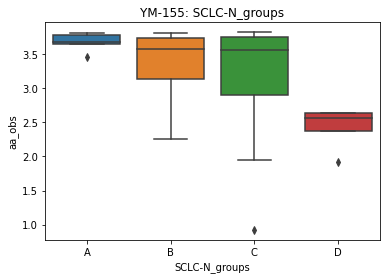

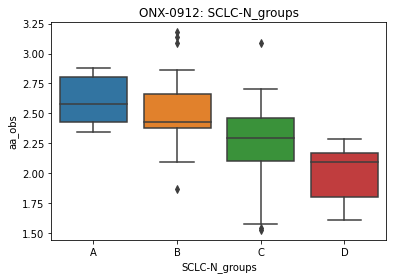

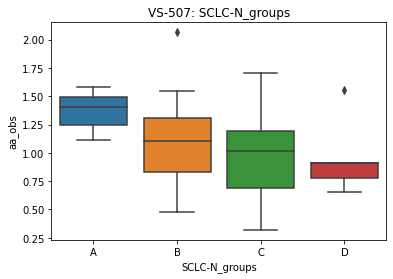

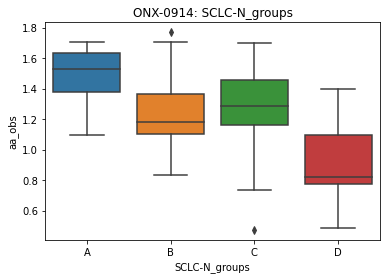

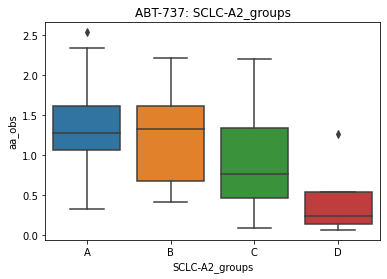

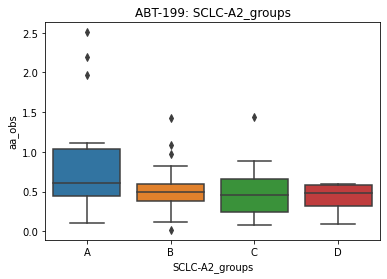

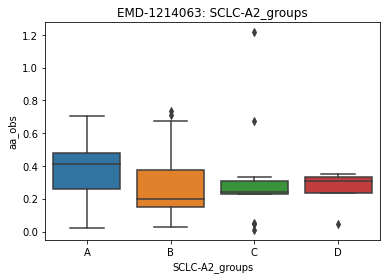

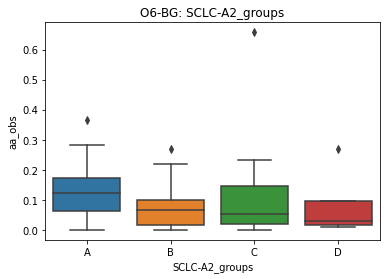

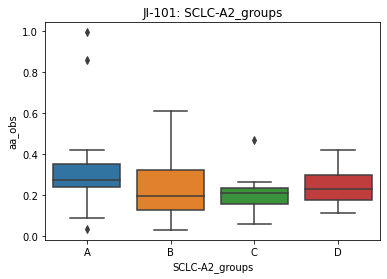

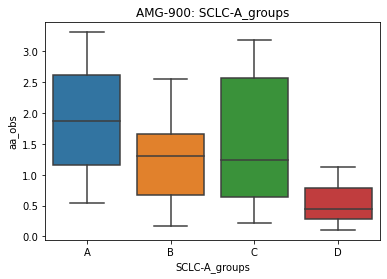

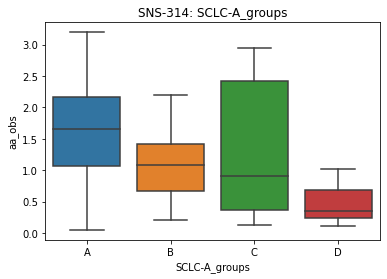

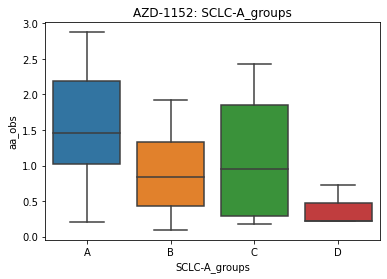

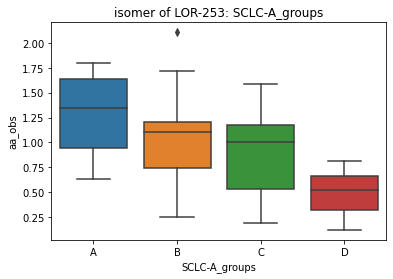

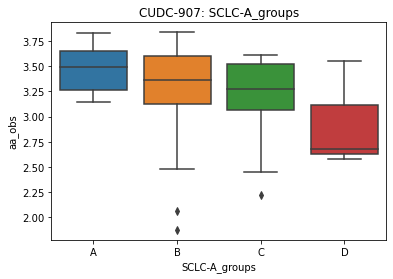

In [27]:
aa_obs_score, p_corrected, p_values_obs, sig_drugs_obs = enriched_dr('aa_obs')

In [28]:
for i,r in target_df.iterrows():
    l = list(r.DRUGS.split(','))
    for d in sig_drugs_obs:
        if d.upper() in [x.upper() for x in l]:
            print(d,r.TARGET)

ABT-199 BCL2
17-AAG HSP90AA1
isomer of LOR-253 INDUCTION OF KLF4
ARRY-520 (isomer A) KSP
AZD-8055 MTORC1
AZD-8055 MTORC2
O6-BG O6-ALKYLGUANINE DNA ALKYLTRANSFERASE
CUDC-907 PI3K


In [29]:
dr

,index,cell_line,drug,aa,aa_obs,emax,emax_obs,einf,ec50,ic50,hill,SCLC-Y_groups,SCLC-P_groups,SCLC-N_groups,SCLC-A2_groups,SCLC-A_groups
0,519,COLO668,10058-F4,NaN,0.026270,NaN,0.890100,NaN,NaN,NaN,NaN,D,C,D,A,C
1,520,COLO668,10074-G5,0.004964,0.038568,0.859417,0.859433,0.472667,1.000000e-05,1.000000e-05,14.305076,D,C,D,A,C
2,521,COLO668,17-AAG,1.631663,1.615248,0.165232,0.140267,0.165208,1.110253e-07,1.318942e-07,2.328694,D,C,D,A,C
3,522,COLO668,17-DMAG,1.969969,1.921832,0.120053,0.013000,0.119921,5.769376e-08,6.773971e-08,1.708338,D,C,D,A,C
4,523,COLO668,1-Methyl-[D]-tryptophan,NaN,0.051735,NaN,0.960933,NaN,NaN,NaN,NaN,D,C,D,A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28004,36298,SW1271,ZD-1694,0.755736,0.746632,0.615357,0.611300,0.540950,2.734875e-07,NaN,0.456437,A,C,D,D,D
28005,36299,SW1271,ZIP-301,2.246580,2.231742,0.104835,0.105367,0.104636,3.070358e-08,3.608387e-08,1.454183,A,C,D,D,D
28006,36300,SW1271,ZM-336372,NaN,0.206636,NaN,0.919367,NaN,NaN,NaN,NaN,A,C,D,D,D
28007,36301,SW1271,Zolendronic acid,NaN,0.000000,NaN,1.036367,NaN,NaN,NaN,NaN,A,C,D,D,D


1. SCLC-Y
    - Cpd-401
    - Rapamycin - mTOR
    - INK-128 - mTOR
    - AZD-2014 - mTOR
    - 17-AAG * - HSP90
    - SB-743921 (AA) - KSP inhibitor (microtubule associated motor protein)
    - MK-7965 (AA) - cyclin dependent kinase inhibitor
    - XL-518 (isomer 1) (AA) - MEK inhibitor
    - XL-888 (AA) - HSP90
2. SCLC-P
    - docetaxel - binds MTs
    - cabazitaxel - MT inhibitor
    - SB-743921 - KSP
    - ARRY-520 (isomer A) * - KSP
    - paclitaxel * - MT
    - pralatrexate (AA) - folate antogonist
    - AS-703569 (AA) - multi-kinase inhibitor
    - ixabepilone (AA) - MT
3. SCLC-N
    - LY-2606368 * - CHK1
    - ONX-0912 * - proteosome inhibitor
    - XL-880 - MET and VEGFR2 inhibitor
    - R-547 - CDK inhibitor
    - azacitidine - antimetabolite
    - BI-2536 (AA) - Plk1 (cell mitosis kinase)
    - VS-507 (AA)
    - CEP-18770 (AA) - proteosome inhibitor
4. SCLC-A2
    - ABT-199 - BCL2
    - BAM7 - BCL2
    - SB-239063 * - MAPK
    - PKM2 Activator 9 - pyruvate kinase
    - ZM-336372 - Raf
    - ARQ-680 (AA) - BRAF
    - GW-5074 (AA) - Raf1
    - BML-277 (AA) - Chk2
    - vismodegib (AA) - HH pathway
5. SCLC-A
    - topotecan - topo
    - GENZ-644282 * - topo
    - SNS-314 * - AKI
    - 7-Ethyl-10-hydroxycamptothecin - DNA replication
    - AMG-900 - AKI
    - ABT-348 (AA) - AKI
    - BMN-673 (AA) - PARP1/2
    - etoposide (AA) - topo

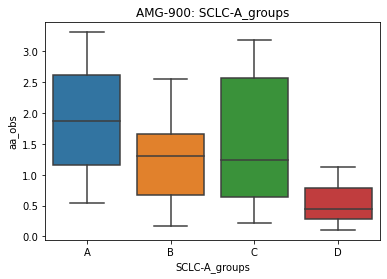

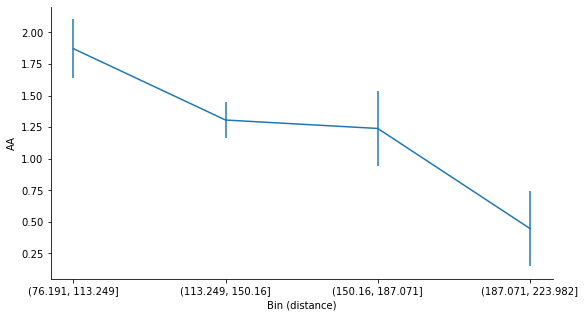

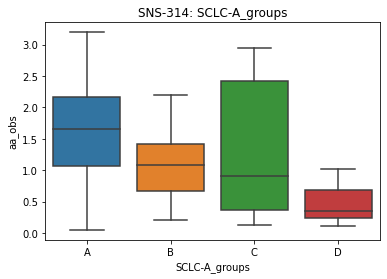

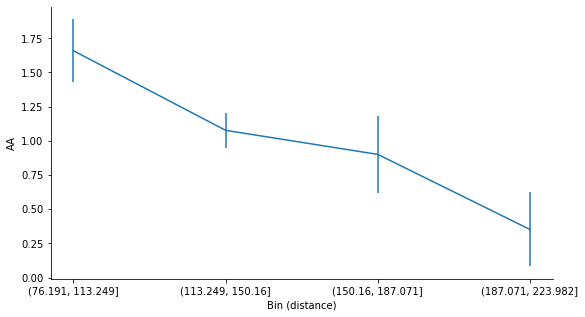

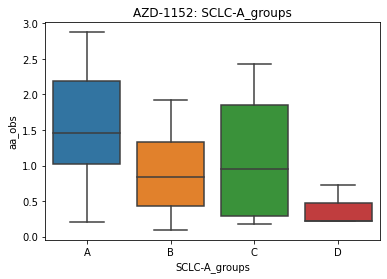

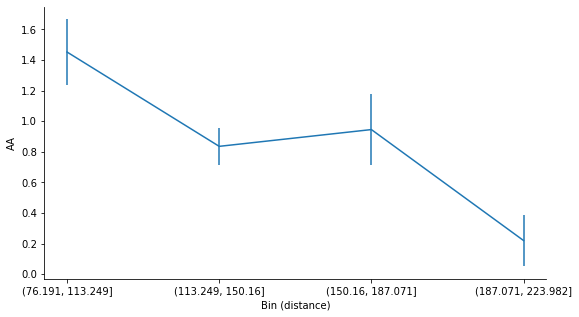

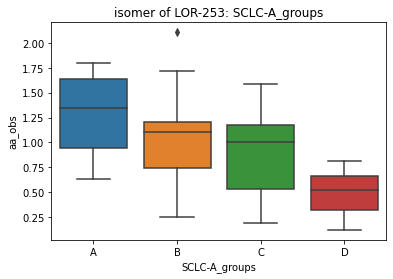

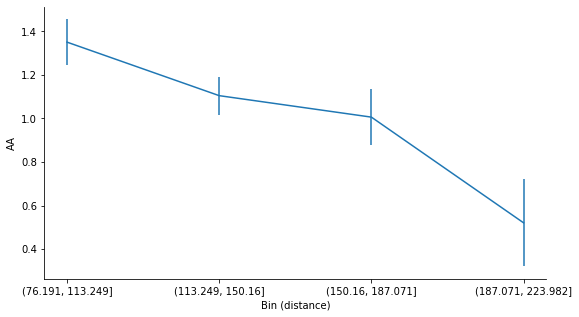

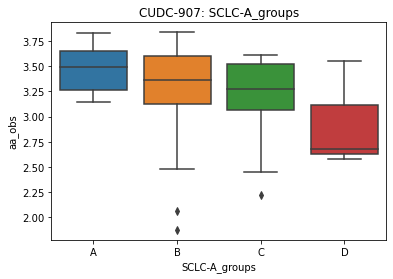

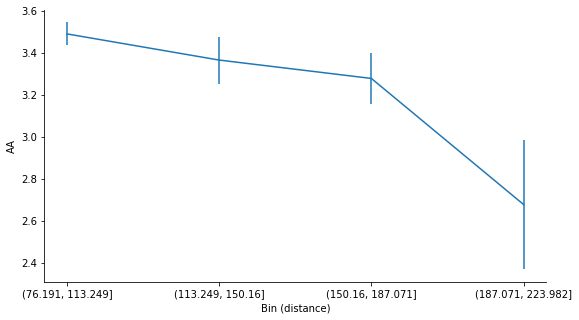

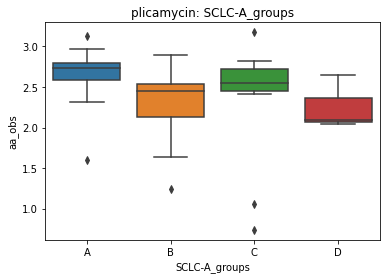

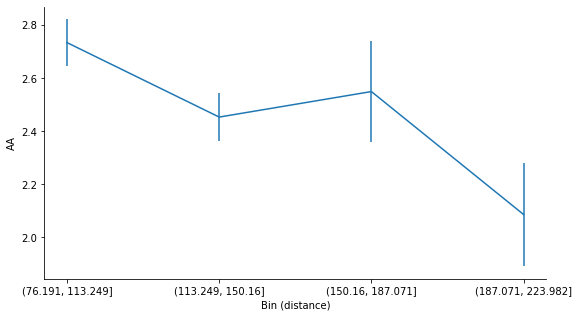

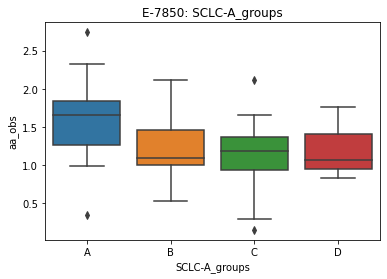

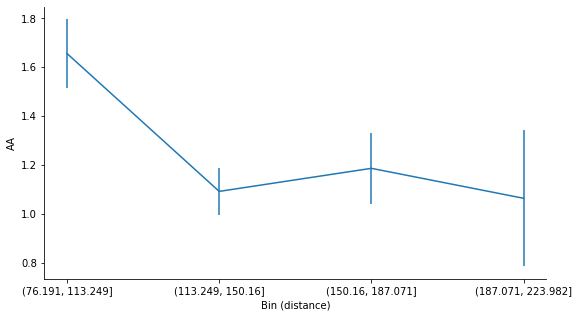

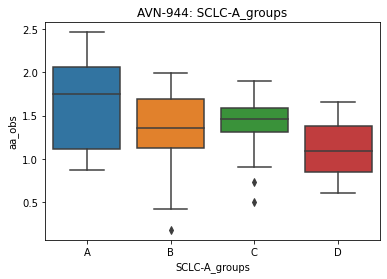

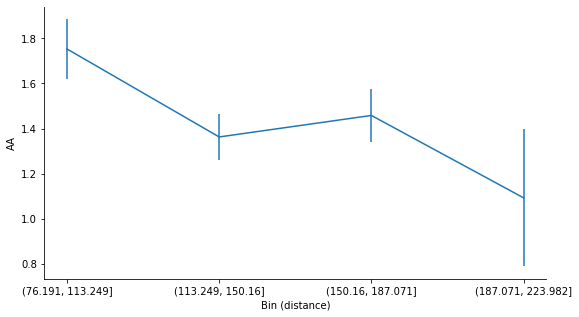

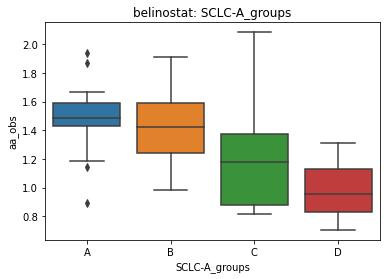

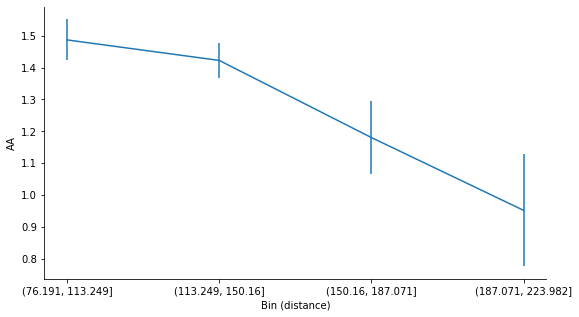

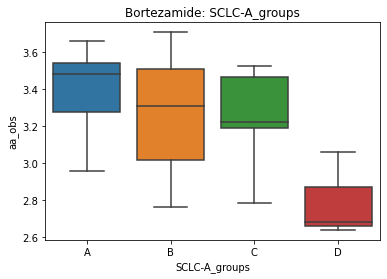

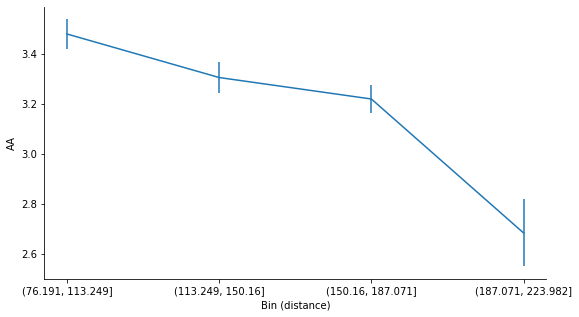

In [30]:
g = 'SCLC-A_groups'
for i in aa_obs_score.loc[p_values_obs.loc[p_values_obs[g] < 0.05].index].sort_values(g, ascending = False).head(10).index:
    sns.boxplot(data=dr.loc[dr.drug ==i], x = g, y = 'aa_obs')
    plt.title(i + ": " + g)
    plt.show()
    tmp = dr.loc[dr.drug ==i]
    med_tmp = tmp.groupby(g).median()['aa_obs']
    std_tmp = tmp.groupby(g).sem()['aa_obs']

    fig, ax = plt.subplots(figsize=(9,5))
    ax.errorbar(['(76.191, 113.249]', '(113.249, 150.16]' ,'(150.16, 187.071]', '(187.071, 223.982]'], med_tmp, std_tmp, color='tab:blue', ecolor='tab:blue')
    ax.set_xlabel('Bin (distance)')
    ax.set_ylabel('AA')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    

In [31]:
p_values_obs

,SCLC-Y_groups,SCLC-P_groups,SCLC-N_groups,SCLC-A2_groups,SCLC-A_groups
10058-F4,0.02254,0.193185,0.347126,NaN,NaN
10074-G5,NaN,NaN,0.1052,0.020371,NaN
17-AAG,0.022843,0.056362,NaN,NaN,NaN
17-DMAG,0.140243,0.034873,NaN,NaN,0.488666
1-Methyl-[D]-tryptophan,0.061987,0.484914,NaN,NaN,0.767455
...,...,...,...,...,...
ZD-1694,0.292881,0.024782,0.276999,NaN,NaN
ZIP-301,0.277552,0.014433,0.430783,NaN,NaN
ZM-336372,NaN,0.507679,NaN,0.080834,NaN
Zolendronic acid,0.853343,NaN,0.561736,0.563591,0.224147


## Enrichment of target groups

In [32]:
target_classes = pd.read_csv('../../data/drug-response/drug_targets_updated.csv', index_col=0)
target_classes.index = [i.upper() for i in target_classes.index]

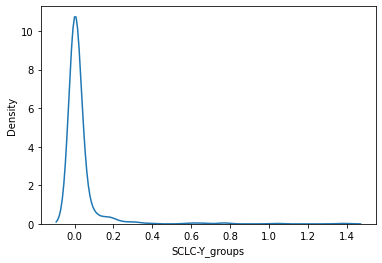

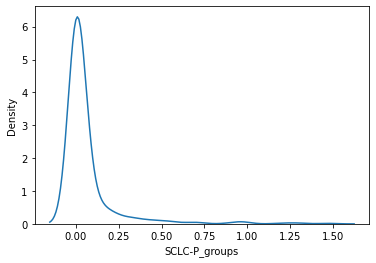

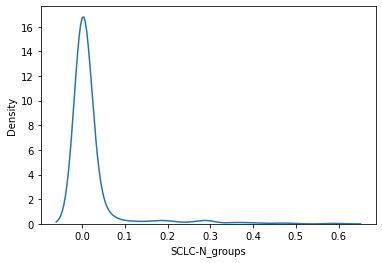

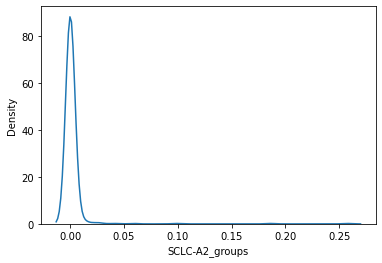

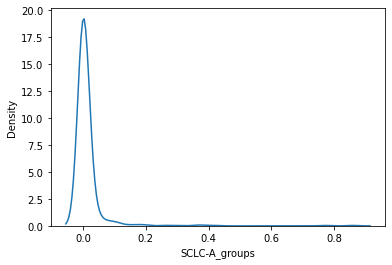

In [33]:
for g in  [i for i in dr.columns if '_group' in i]:
    sns.kdeplot(aa_obs_score[g])
    plt.show()

In [34]:
def enriched_targets(g, cutoff = 0.05, threshold = 0.1):
    tmp_p = p_values_obs.loc[p_values_obs[g] < cutoff].sort_values(g)
    drugs = tmp_p.index
    classes = []
    for d in drugs:
        if aa_obs_score.loc[d,g] > threshold:
            if d.upper() in target_classes.index:
                classes.append(target_classes.loc[d.upper(), 'PATHWAY'])
            else:
                classes.append('Unknown')
    unique_targets = pd.DataFrame(np.unique(classes, return_counts=True), index=['target','count']).T
    unique_targets.index = unique_targets.target
    unique_targets= unique_targets.drop('target', axis = 1 )
    
    return unique_targets

In [35]:
 enriched_targets(g,threshold=0).index

Index(['AURORA KINASE', 'CELL CYCLE', 'CHROMATIN', 'CHROMATIN HISTONE',
       'CYTOSKELETAL SIGNALING', 'DNA ALKYLATOR', 'DNA REPLICATION',
       'DNA/RNA SYNTHESIS', 'EGFR INHIBITOR', 'IMMUNE SYSTEM',
       'JAK/STAT SIGNALING', 'MAPK SIGNALING', 'MEK INHIBITOR', 'METABOLISM',
       'OTHER', 'PI3K/AKT/MTOR', 'PROTEIN TYROSINE KINASE',
       'TRANSMEMBRANE TRANSPORTERS', 'Unknown'],
      dtype='object', name='target')

In [36]:
distances_groupby_cline

,SCLC-Y,SCLC-P,SCLC-N,SCLC-A2,SCLC-A
COLO668,219.711613,163.151579,190.111824,108.962738,168.018820
CORL24,222.904409,194.007225,147.307784,179.723460,145.958027
CORL279,222.164942,182.309984,134.033402,139.243882,142.255942
CORL311,221.129705,129.052134,156.731679,170.742741,162.306829
CORL47,230.207672,176.544479,139.077497,132.215445,122.241732
...,...,...,...,...,...
NCIH889,226.670810,172.126948,149.957297,119.682615,131.418198
SBC5,145.433444,168.450071,178.199310,194.844602,201.213696
SCLC21H,221.953827,172.205011,116.052643,159.644444,143.524457
SHP77,199.426186,170.032879,162.100698,129.161671,173.163127


In [37]:
[str(i) for i in pd.cut(distances_groupby_cline[g.split("_")[0]], bins = 4).unique().sort_values()]

['(76.191, 113.249]',
 '(113.249, 150.16]',
 '(150.16, 187.071]',
 '(187.071, 223.982]']

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


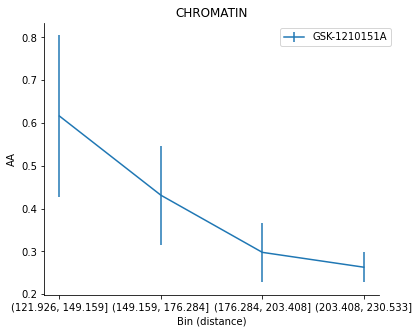

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


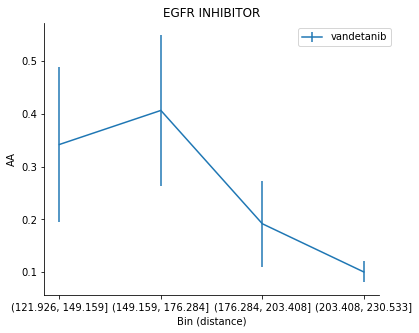

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_lau

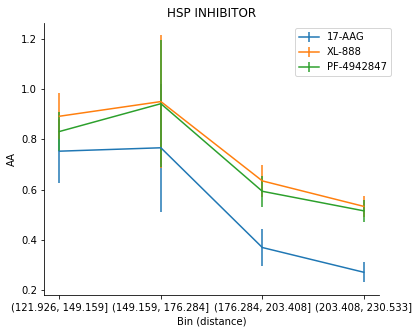

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


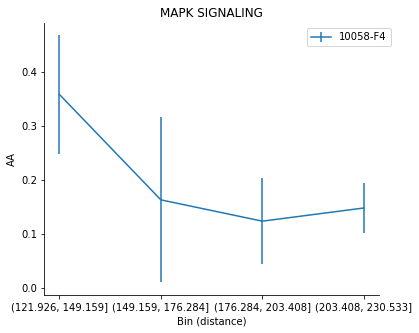

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


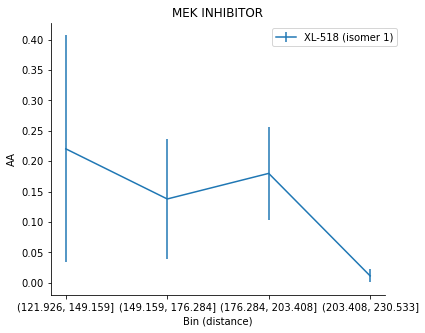

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_lau

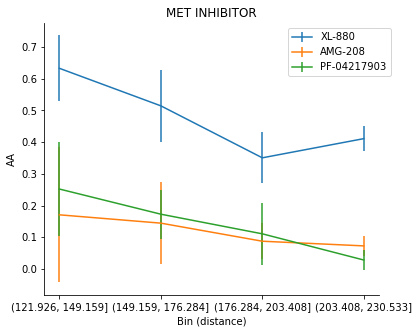

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


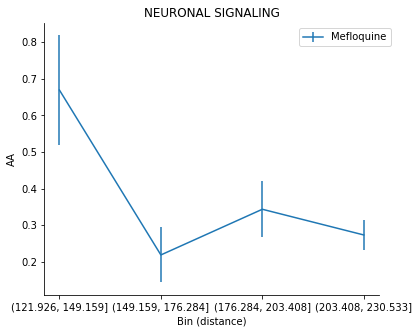

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


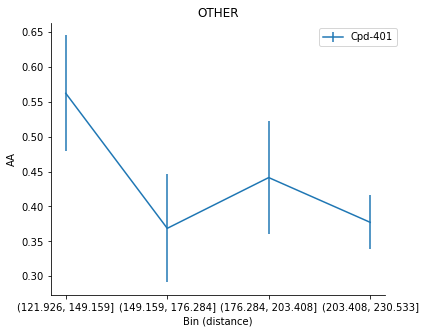

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_lau

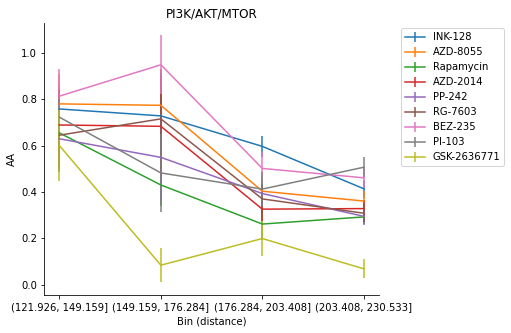

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_lau

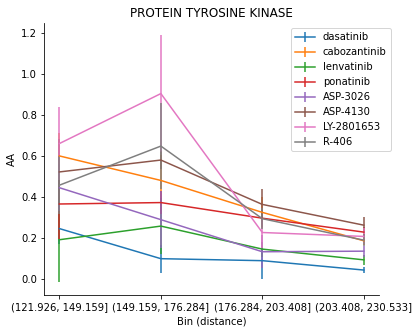

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


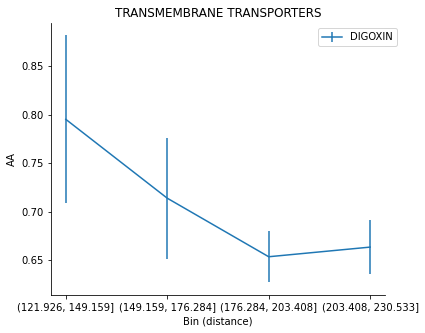

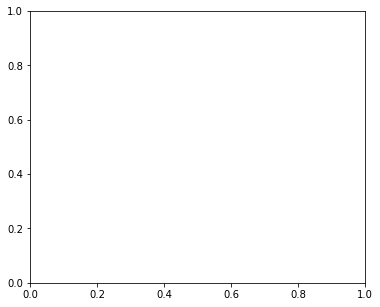

In [86]:
g = 'SCLC-Y_groups'
for p in enriched_targets(g,threshold=0).index:
    fig, ax = plt.subplots(figsize=(6,5))
    for i in aa_obs_score.loc[p_values_obs.loc[p_values_obs[g] < 0.05].index].sort_values(g, ascending = False).index:
        if i.upper() in target_classes.index:
            if target_classes.loc[i.upper(), 'PATHWAY'] == p:
                # sns.boxplot(data=dr.loc[dr.drug ==i], x = g, y = 'aa_obs')
                # plt.title(i + ": " + g)
                # plt.show()
                tmp = dr.loc[dr.drug ==i]
                tmp['aa_obs'] = ((tmp['aa_obs']-tmp['aa_obs'].min())/(tmp['aa_obs'].max()-tmp['aa_obs'].min()))
                med_tmp = tmp.groupby(g).median()['aa_obs']
                std_tmp = tmp.groupby(g).sem()['aa_obs']
                bin_name = [str(i) for i in pd.cut(distances_groupby_cline[g.split("_")[0]], bins = 4).unique().sort_values()]
                ax.errorbar(bin_name, med_tmp, std_tmp, label = i)
                ax.set_xlabel('Bin (distance)')
                ax.set_ylabel('AA')
                # plt.xticks(rotation = 15)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                handles, labels = ax.get_legend_handles_labels()

                # reverse the order
                ax.legend(handles, labels)
                plt.legend(bbox_to_anchor=(1.05, 1))

                plt.title(p)
                # plt.show()
    plt.savefig(f'./figures/drugs_new/{p.replace("/","_")}_{g.split("_")[0]}.pdf')
    plt.show()

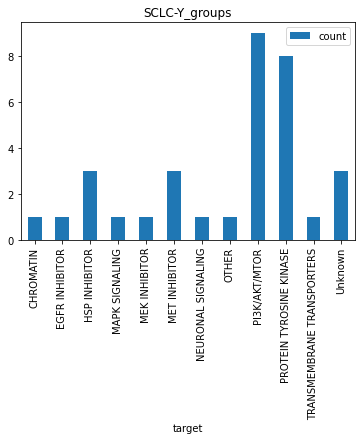

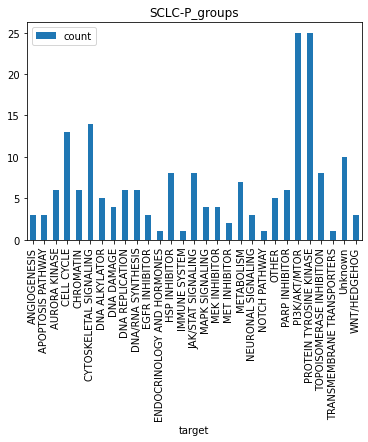

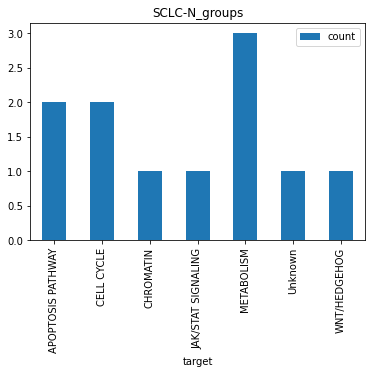

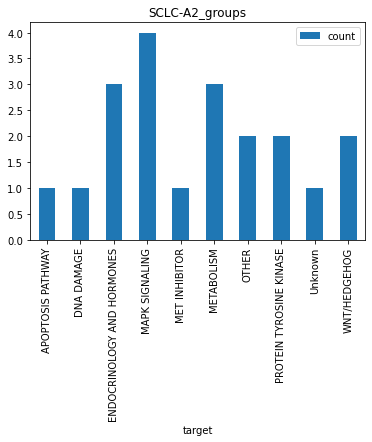

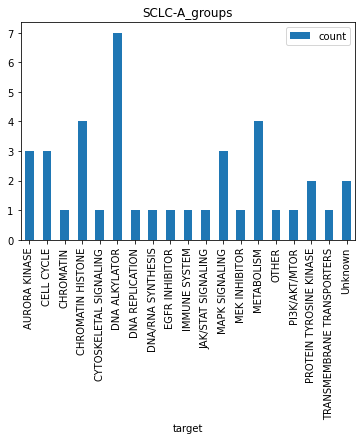

In [39]:
for g in [i for i in dr.columns if '_group' in i]:
    enriched_targets(g,threshold=0).plot.bar()
    plt.title(g )
    plt.savefig(f'./figures/drugs_new/targets_{g}.pdf')
    plt.show()

In [75]:
target_classes.loc[target_classes.PATHWAY == 'TOPOISOMERASE INHIBITION']

,TARGET,PATHWAY
7-ETHYL-10-HYDROXYCAMPTOTHECIN,TOPO1,TOPOISOMERASE INHIBITION
DAUNORUBICIN,TOPO2,TOPOISOMERASE INHIBITION
DOXORUBICIN,TOPO2,TOPOISOMERASE INHIBITION
ETOPOSIDE,TOPO2,TOPOISOMERASE INHIBITION
GENZ-644282,"TOPO1, TOPO2",TOPOISOMERASE INHIBITION
IRINOTECAN,"TOPO1, TOPO2",TOPOISOMERASE INHIBITION
MITOXANTRONE,"TOPO1, TOPO2",TOPOISOMERASE INHIBITION
MLN-576,"TOPO1, TOPO2",TOPOISOMERASE INHIBITION
SNS-595; SPC-595,"TOPO1, TOPO2",TOPOISOMERASE INHIBITION
TENIPOSIDE,TOPO2,TOPOISOMERASE INHIBITION


In [85]:
p_values_obs.loc['Valrubicin']

SCLC-Y_groups     0.772707
SCLC-P_groups     0.000724
SCLC-N_groups          NaN
SCLC-A2_groups         NaN
SCLC-A_groups     0.090403
Name: Valrubicin, dtype: object

<AxesSubplot:xlabel='SCLC-A_groups', ylabel='aa_obs'>

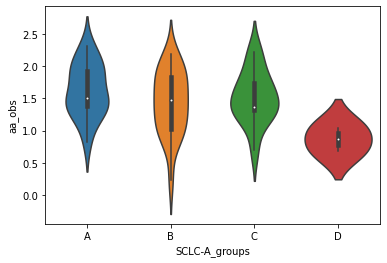

In [84]:
sns.violinplot(data=dr.loc[dr.drug =='Valrubicin'], x = 'SCLC-A_groups', y = 'aa_obs')
